In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from numpy import NaN
import numpy as np
import os



In [4]:
# file upload from google drive
from google.colab import drive
drive.mount('/content/drive')

os.chdir('./drive/MyDrive/kidney')

Mounted at /content/drive


In [5]:
kidpan_data_org_selected = pd.read_csv('kidpan_data_org_selected.csv', header=0, sep=',', low_memory=False)

In [6]:
# confirm data
kidpan_data_org_selected #dim should be 8566*59

,Unnamed: 0,ABO_MAT,AGE,AGE_DON,AMIS,BMI_DON_CALC,BMI_TCR,BMIS,CMV_STATUS,COLD_ISCH_KI,...,TBILI_DON,TOT_SERUM_ALBUM,TRTREJ1Y_KI,TRTREJ6M_KI,TX_PROCEDUR_TY_KI,TXKID,URINE_INF_DON,USE_WHICH_PRA,VASODIL_DON,WORK_INCOME_TCR
0,212610,1.0,39,47,2,34.165166,23.5689,2,P,8.50,...,1.9,4.2,N,N,101,L,0,P,N,Y
1,214338,1.0,36,42,1,18.970387,32.9224,2,P,8.00,...,3.0,4.0,N,N,101,L,1,C,N,N
2,246752,1.0,57,18,2,21.229042,36.2471,2,P,14.00,...,1.8,3.9,N,N,102,R,0,P,N,N
3,248513,1.0,43,23,2,21.671258,19.3941,1,P,9.00,...,1.4,3.9,N,N,101,L,1,P,N,N
4,253472,1.0,46,18,2,23.286464,21.1127,2,P,10.00,...,1.3,3.6,N,N,102,R,0,C,N,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,578662,1.0,61,24,2,31.095741,23.9574,1,N,21.80,...,0.3,3.9,N,N,102,R,0,C,N,Y
8562,578698,1.0,55,46,2,32.900284,26.2577,2,P,17.00,...,1.3,3.8,N,N,102,R,0,P,N,N
8563,579030,2.0,55,24,1,28.209908,33.7928,1,P,9.45,...,1.3,3.6,N,N,101,L,0,C,N,Y
8564,579728,1.0,63,45,0,25.774806,30.1055,0,P,25.23,...,0.3,3.6,Y,N,102,R,0,P,N,N


Data Cleaning

In [7]:
# variable initially in percentage so remove the % letter at the end
kidpan_data_org_selected['KDPI'] = kidpan_data_org_selected['KDPI'].str[:-1]

In [8]:
# dropped rows with categorical values of U for better interpretation
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['CMV_STATUS'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['DIAL_TRR'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['DRUGTRT_COPD'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['EXH_PERIT_ACCESS'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['EXH_VASC_ACCESS'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['HIST_CANCER_DON'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['MALIG_TCR_KI'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['PERIP_VASC'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['PT_STEROIDS_DON'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['TATTOOS'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['VASODIL_DON'] != 'U']
kidpan_data_org_selected = kidpan_data_org_selected[kidpan_data_org_selected['WORK_INCOME_TCR'] != 'U']


In [10]:
# dropped column DON_TY since there is only one categorical option
# dropped column DWFG_KI since it does not affect survival time/status. recipient is already dead.
# dropped column HIV_SEROSTATUS since not sure how to interpret different categories
# dropped column TX_PROCEDUR_TY_KI since not sure how to interpret different categories
# dropped column TXKID since not sure how to interpret different categories
# dropped column USE_WHICH_PRA since not sure how to interpret different categories(PENDING; need to combine CURRENT_PRA and PEAK_PRA)

kidpan_data_org_selected = kidpan_data_org_selected.loc[:, ~kidpan_data_org_selected.columns.isin(['DON_TY', 'DWFG_KI', 'HIV_SEROSTATUS', 'TX_PROCEDUR_TY_KI', 'TXKID', 'USE_WHICH_PRA'])]

In [13]:
# check dimension of data before proceeding should be 7257*53
kidpan_data_org_selected.shape

(7257, 53)

In [14]:
# set datatypes
from pandas.core.arrays import categorical
categoricalCols =["CMV_STATUS", "DIAB", "DIAL_TRR", "DONATION", "DRUGTRT_COPD", "EXH_PERIT_ACCESS",
                  "EXH_VASC_ACCESS",	"FIRST_WK_DIAL",	"GENDER", "GENDER_DON", "HIST_CANCER_DON",	"HIST_HYPERTENS_DON",
                  "MALIG_TCR_KI", "NON_HRT_DON", "ON_DIALYSIS",	"PERIP_VASC",	"PT_STEROIDS_DON", "PUMP_KI",	"RT_KI_BIOPSY",
                  "SHARE_TY",	"TATTOOS", "TRTREJ1Y_KI",	"TRTREJ6M_KI", "VASODIL_DON",
                  "WORK_INCOME_TCR"]
cols=[i for i in kidpan_data_org_selected.columns if i not in categoricalCols]

for col in cols:
  kidpan_data_org_selected[col]= kidpan_data_org_selected[col].astype(float)
for col in categoricalCols:
  kidpan_data_org_selected[col]= kidpan_data_org_selected[col].astype('category')

In [15]:
# drop KDRI_MED sinc KDPI is mapping of the KDRI, a measure of relative risk, to a cumulative percentage scale.
# The KDPI is calculated to the nearest integer percentage value and ranges from 0% to 100%.

# also suspect HLAMIS is a calculated result of DRMIS, AMIS, BMIS so will drop them and keep HLAMIS

# suspect DAYSWAIT_CHRON_KI, DAYSWAIT_ALLOC, DAYSWAIT_CHRON are very similar.
# we choose to move forward with DAYSWAIT_ALLOC which is most intuitive to understand and drop other two

# KDPI takes in AGE as a input variable. however i decided to keep both variables considering correlation is 0.699(not too bad), and i'm curious of AGE variable standalone effect.
# CURRENT_PRA and END_CPRA highly correlated(over 0.80), based on feature importance in later modeling, we drop CURRENT_PRA

# drop AGE since it's time-dependent
kidpan_data_org_selected = kidpan_data_org_selected.drop(['KDRI_MED', 'DRMIS', 'AMIS', 'BMIS', 'DAYSWAIT_CHRON_KI', 'DAYSWAIT_CHRON', 'CURRENT_PRA', 'AGE'], axis = 1)

In [16]:
# check dimension of data before proceeding should be 7257*45
kidpan_data_org_selected.shape

(7257, 45)

Text(0.5, 1.0, 'Survival Count after Kidney Transplant')

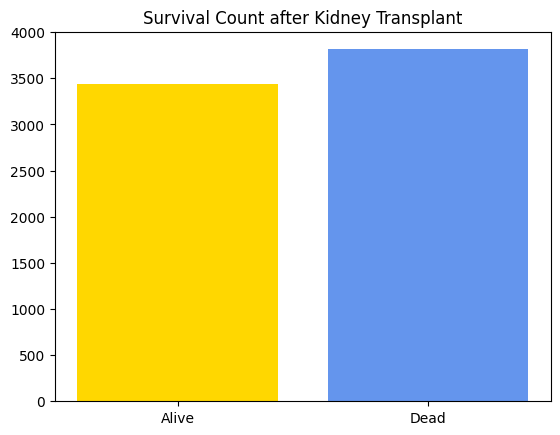

In [17]:
status = kidpan_data_org_selected.groupby(['GSTATUS_KI']).count()['ABO_MAT']
status = pd.DataFrame(status.rename({0:"Alive", 1: "Dead"}, axis = 0)).reset_index()
plt.bar(status['GSTATUS_KI'], status['ABO_MAT'], color = ['gold', 'cornflowerblue'])
plt.title('Survival Count after Kidney Transplant')

<ipython-input-18-dbe05bbe7518>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = kidpan_data_org_selected.corr()


<Axes: >

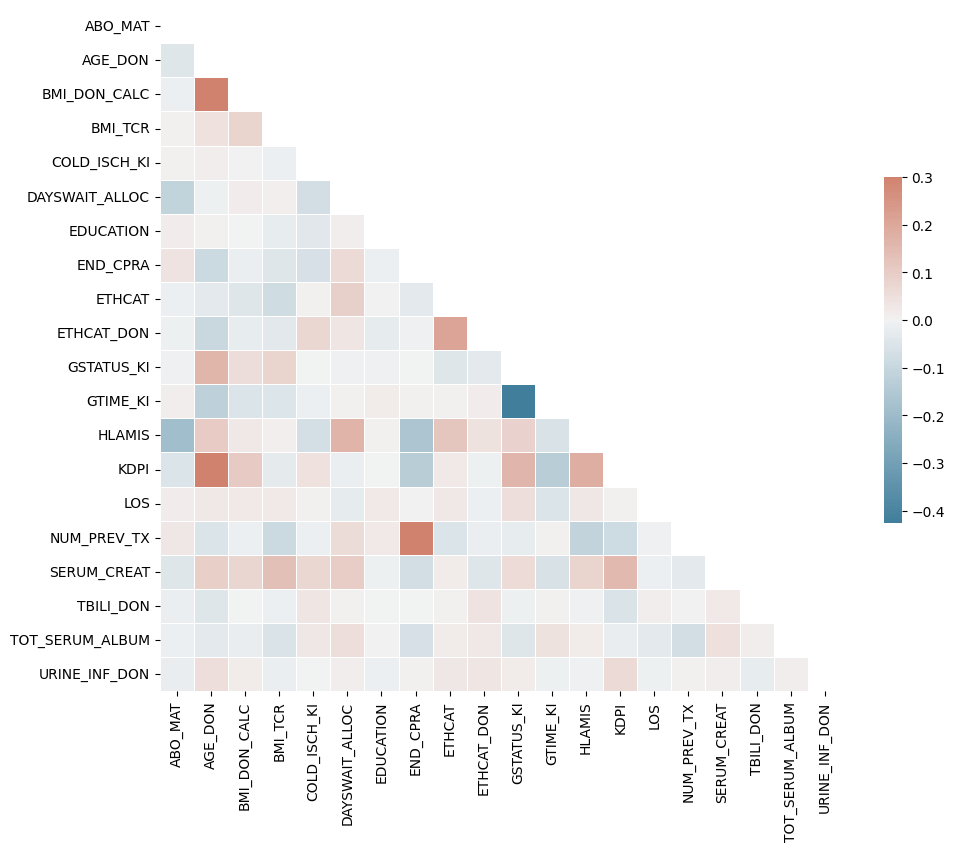

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = kidpan_data_org_selected.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

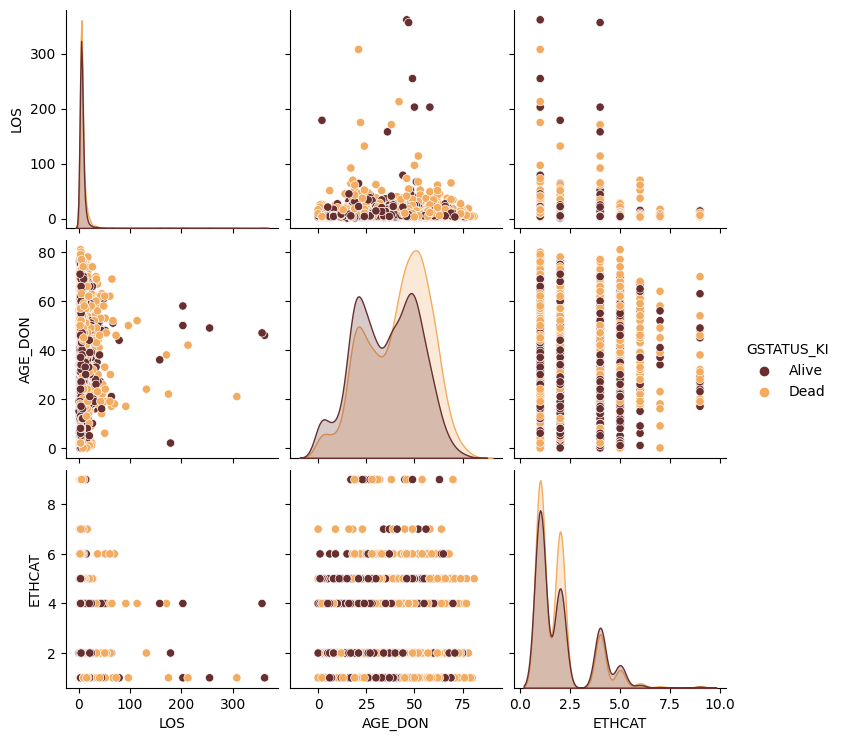

In [19]:
#Plotting following features
import seaborn as sns
To_Plot = ['GSTATUS_KI', 'LOS', 'AGE_DON', 'ETHCAT']
g = sns.pairplot(kidpan_data_org_selected[To_Plot], hue= "GSTATUS_KI", palette= (["#682F2F","#F3AB60"]))

# replace labels
new_labels = ['Alive', 'Dead']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

# plt.show()

In [ ]:
data_y = kidpan_data_org_selected[['GSTATUS_KI', 'GTIME_KI']]
data_x = kidpan_data_org_selected.loc[:, ~kidpan_data_org_selected.columns.isin(['GSTATUS_KI', 'GTIME_KI'])]

# to prep dat for CoxPHSurvivalAnalysis
data_y['GSTATUS_KI'] = data_y['GSTATUS_KI'].map({1.0: False, 0.0: True})

<ipython-input-14-d1299707c6ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['GSTATUS_KI'] = data_y['GSTATUS_KI'].map({1.0: False, 0.0: True})


In [ ]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.5 MB/s eta 0:00:00


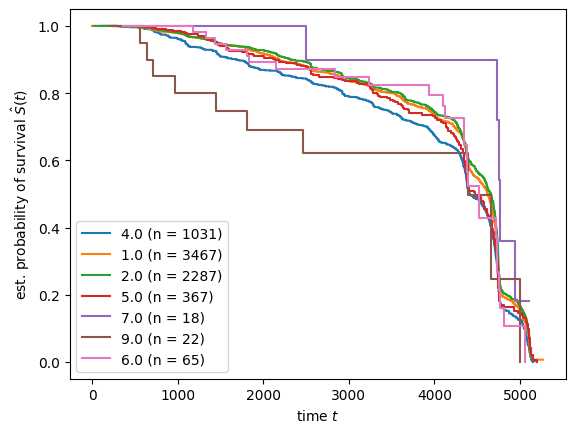

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

for value in data_x["ETHCAT"].unique():
    mask = data_x["ETHCAT"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["GSTATUS_KI"][mask],
                                                           data_y["GTIME_KI"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Text(0.5, 1.0, 'Kaplan-Meier Curve based on Gender')

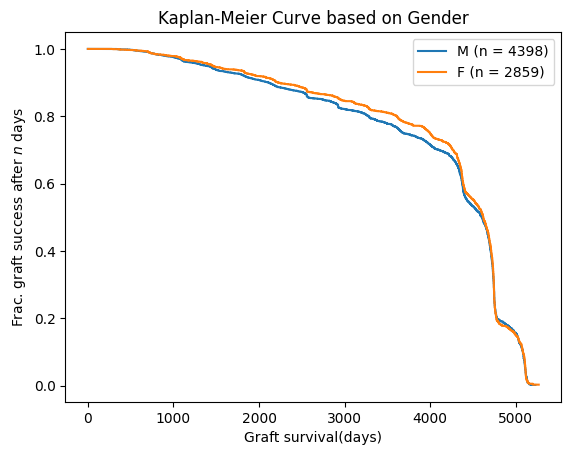

In [ ]:
for value in data_x["GENDER"].unique():
    mask = data_x["GENDER"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["GSTATUS_KI"][mask],
                                                           data_y["GTIME_KI"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("Frac. graft success after $n$ days")
plt.xlabel("Graft survival(days)")
plt.legend(loc="best")
plt.title("Kaplan-Meier Curve based on Gender")

Text(0.5, 1.0, 'Kaplan-Meier Curve based on Education Level')

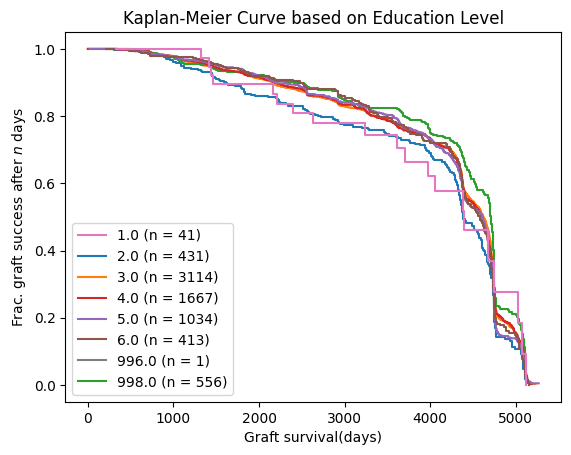

In [ ]:
for value in data_x["EDUCATION"].unique():
    mask = data_x["EDUCATION"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["GSTATUS_KI"][mask],
                                                           data_y["GTIME_KI"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("Frac. graft success after $n$ days")
plt.xlabel("Graft survival(days)")

# update legend order
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [6, 0, 1, 3, 4, 5, 7, 2]
#add legend to plot
plt.legend(loc = "best")
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title("Kaplan-Meier Curve based on Education Level")



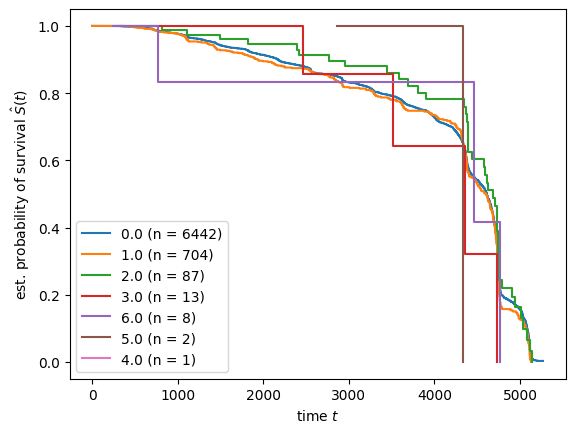

In [ ]:
for value in data_x["NUM_PREV_TX"].unique():
    mask = data_x["NUM_PREV_TX"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["GSTATUS_KI"][mask],
                                                           data_y["GTIME_KI"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [ ]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1e75dc1b0e4be29312436a6c35e3a24a097bf92d49c1e34cbb2079fb1ed14a8c
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
data_x_numeric2 = data_x_numeric.reset_index()
test3 = pd.concat([data_x_numeric2[['LOS', 'ETHCAT','AGE_DON','EDUCATION', 'RT_KI_BIOPSY=Y','GENDER=M',
                                   'KDPI', 'HIST_HYPERTENS_DON=Y', 'ON_DIALYSIS=Y', 'COLD_ISCH_KI']], pd.DataFrame(data_y)], axis=1)
test3



# LOS                     0.515500
# ETHCAT                  0.515487
# AGE_DON                 0.515236
# EDUCATION               0.514442
# RT_KI_BIOPSY=Y          0.511475
# GENDER=M                0.511318
# KDPI                    0.511194
# HIST_HYPERTENS_DON=Y    0.510826
# ON_DIALYSIS=Y           0.509443
# COLD_ISCH_KI            0.509412



NameError: ignored

In [ ]:
import lifelines
# Fit into model
cph = lifelines.CoxPHFitter()
cph.fit(test3, duration_col='GTIME_KI', event_col='GSTATUS_KI')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7257 total observations, 3814 right-censored observations>
             duration col = 'GTIME_KI'
                event col = 'GSTATUS_KI'
      baseline estimation = breslow
   number of observations = 7257
number of events observed = 3443
   partial log-likelihood = -25649.44
         time fit was run = 2023-05-29 23:50:40 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
LOS                   -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
ETHCAT                 0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
AGE_DON               -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
EDUCATION             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
RT_KI_BIOPSY=Y         0.01       1.01       0.04            -0.08             0.10                 0.92                 1.10
GENDER=M               0.05       1.05       0.03            -0.02             0.12                 0.98                 1.12
KDPI                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HIST_HYPERTENS_DON=Y  -0.10       0.90       0.05            -0.20            -0.01                 0.82                 0.99
ON_DIALYSIS=Y         -0.00       1.00       0.04            -0.08             0.08                 0.92                 1.08
COLD_ISCH_KI          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                       cmp to     z      p   -log2(p)
covariate                                            
LOS                      0.00 -0.94   0.35       1.54
ETHCAT                   0.00  2.74   0.01       7.36
AGE_DON                  0.00 -2.06   0.04       4.66
EDUCATION                0.00 -2.97 <0.005       8.41
RT_KI_BIOPSY=Y           0.00  0.18   0.85       0.23
GENDER=M                 0.00  1.43   0.15       2.71
KDPI                     0.00  1.14   0.25       1.98
HIST_HYPERTENS_DON=Y     0.00 -2.10   0.04       4.81
ON_DIALYSIS=Y            0.00 -0.07   0.95       0.08
COLD_ISCH_KI             0.00 -0.20   0.84       0.24
---
Concordance = 0.53
Partial AIC = 51318.88
log-likelihood ratio test = 31.71 on 10 df
-log2(p) of ll-ratio test = 11.12

## Model 1: Regular Cox PH Model

In [ ]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x) #dropped categorical variable 'DON_TY', because it has only 1 values
data_x_numeric

,ABO_MAT,AGE_DON,BMI_DON_CALC,BMI_TCR,CMV_STATUS=P,COLD_ISCH_KI,DAYSWAIT_ALLOC,DIAB=2,DIAB=3,DIAB=4,...,SHARE_TY=4,SHARE_TY=5,TATTOOS=Y,TBILI_DON,TOT_SERUM_ALBUM,TRTREJ1Y_KI=Y,TRTREJ6M_KI=Y,URINE_INF_DON,VASODIL_DON=Y,WORK_INCOME_TCR=Y
0,1.0,47.0,34.165166,23.5689,1.0,8.50,2196.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.9,4.2,0.0,0.0,0.0,0.0,1.0
1,1.0,42.0,18.970387,32.9224,1.0,8.00,4346.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,4.0,0.0,0.0,1.0,0.0,0.0
2,1.0,18.0,21.229042,36.2471,1.0,14.00,3359.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.8,3.9,0.0,0.0,0.0,0.0,0.0
3,1.0,23.0,21.671258,19.3941,1.0,9.00,3011.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.4,3.9,0.0,0.0,1.0,0.0,0.0
5,1.0,61.0,26.695333,24.5630,1.0,13.00,3069.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.6,4.2,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,1.0,24.0,31.095741,23.9574,0.0,21.80,8.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.3,3.9,0.0,0.0,0.0,0.0,1.0
8562,1.0,46.0,32.900284,26.2577,1.0,17.00,18.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.3,3.8,0.0,0.0,0.0,0.0,0.0
8563,2.0,24.0,28.209908,33.7928,1.0,9.45,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.3,3.6,0.0,0.0,0.0,0.0,1.0
8564,1.0,45.0,25.774806,30.1055,1.0,25.23,4.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.3,3.6,1.0,0.0,0.0,0.0,0.0


In [ ]:
def frameToStruct(df):
    # convert dataframe to record array, then cast to structured array
    struct = df.to_records(index=False).view(type=np.ndarray, dtype=list(df.dtypes.items()))

    # return the struct and the row labels
    return struct

data_y = frameToStruct(data_y)
data_y

array([( True, 4742.), (False,  408.), ( True, 2558.), ...,
       ( True, 2340.), (False, 2280.), (False, 1212.)],
      dtype=[('GSTATUS_KI', '?'), ('GTIME_KI', '<f8')])

In [ ]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis(alpha = 0.0001)
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis(alpha=0.0001)

In [ ]:
a = pd.DataFrame(estimator.coef_, index=data_x_numeric.columns)
a.rename(columns = {0: 'coeff'})

,coeff
ABO_MAT,-0.040359
AGE_DON,-0.003508
BMI_DON_CALC,0.004561
BMI_TCR,-0.003527
CMV_STATUS=P,0.035981
COLD_ISCH_KI,-0.000735
DAYSWAIT_ALLOC,0.000028
DIAB=2,-0.075311
DIAB=3,-0.004311
DIAB=4,-0.642383


In [ ]:
import math
np.exp(a.iloc[:,0])

ABO_MAT                 0.960445
AGE_DON                 0.996498
BMI_DON_CALC            1.004571
BMI_TCR                 0.996479
CMV_STATUS=P            1.036636
COLD_ISCH_KI            0.999265
DAYSWAIT_ALLOC          1.000028
DIAB=2                  0.927455
DIAB=3                  0.995698
DIAB=4                  0.526037
DIAB=5                  1.144961
DIAB=998                0.627562
DIAL_TRR=Y              1.022930
DONATION=Y              0.995411
DRUGTRT_COPD=Y          1.092874
EDUCATION               0.999824
END_CPRA                1.001300
ETHCAT                  1.029647
ETHCAT_DON              1.007415
EXH_PERIT_ACCESS=Y      0.791896
EXH_VASC_ACCESS=Y       1.265888
FIRST_WK_DIAL=Y         0.933061
GENDER=M                1.069764
GENDER_DON=M            1.000942
HIST_CANCER_DON=Y       1.029445
HIST_HYPERTENS_DON=Y    0.879742
HLAMIS                  0.998582
KDPI                    1.001640
LOS                     0.999010
MALIG_TCR_KI=Y          0.839588
NON_HRT_DO

In [ ]:
# Measuring the Performance of Survival Models
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["GSTATUS_KI"], data_y["GTIME_KI"], prediction)
result[0] #0.5461637919158796 #0.5433260875936493 without 'AGE' #0.5414813382961327 with AGE_DON without AGE

0.5414813382961327

In [ ]:
#Feature Selection: Which Variable is Most Predictive?
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
sortedScores = pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

In [ ]:
sortedScores[sortedScores > 0.50]

LOS                     0.515500
ETHCAT                  0.515487
AGE_DON                 0.515236
EDUCATION               0.514442
RT_KI_BIOPSY=Y          0.511475
GENDER=M                0.511318
KDPI                    0.511194
HIST_HYPERTENS_DON=Y    0.510826
ON_DIALYSIS=Y           0.509443
COLD_ISCH_KI            0.509412
SHARE_TY=5              0.508853
TATTOOS=Y               0.508841
TBILI_DON               0.508840
BMI_TCR                 0.508712
NON_HRT_DON=Y           0.508610
FIRST_WK_DIAL=Y         0.507800
DIAL_TRR=Y              0.507529
ETHCAT_DON              0.507196
CMV_STATUS=P            0.506884
HLAMIS                  0.505674
TRTREJ1Y_KI=Y           0.505086
MALIG_TCR_KI=Y          0.504683
SHARE_TY=4              0.503854
TRTREJ6M_KI=Y           0.503732
DAYSWAIT_ALLOC          0.503258
ABO_MAT                 0.502708
TOT_SERUM_ALBUM         0.502554
BMI_DON_CALC            0.502132
END_CPRA                0.502116
DIAB=2                  0.501657
DIAB=4    

In [ ]:
sortedScores[sortedScores <= 0.50]

DRUGTRT_COPD=Y       0.499784
DIAB=998             0.499581
PERIP_VASC=Y         0.499515
WORK_INCOME_TCR=Y    0.498953
HIST_CANCER_DON=Y    0.498750
GENDER_DON=M         0.498095
VASODIL_DON=Y        0.497049
DIAB=3               0.496758
SERUM_CREAT          0.495453
PT_STEROIDS_DON=Y    0.493973
dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features)),
                 ('model', CoxPHSurvivalAnalysis())])

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x_numeric, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in tabl

,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
16,17,{'select__k': 17},0.516889,0.520698,0.527817,0.521801,0.004529,1,0.551261,0.533435,0.545168,0.543288,0.007398
14,15,{'select__k': 15},0.519274,0.516506,0.528300,0.521360,0.005036,2,0.550700,0.533519,0.544700,0.542973,0.007120
17,18,{'select__k': 18},0.515064,0.520000,0.527416,0.520827,0.005076,3,0.549988,0.533709,0.545010,0.542902,0.006811
15,16,{'select__k': 16},0.517731,0.516359,0.527891,0.520660,0.005143,4,0.552111,0.533503,0.545051,0.543555,0.007670
12,13,{'select__k': 13},0.516969,0.514459,0.529676,0.520368,0.006661,5,0.549471,0.533561,0.543501,0.542178,0.006562
13,14,{'select__k': 14},0.517170,0.515047,0.528678,0.520298,0.005988,6,0.549681,0.531572,0.543220,0.541491,0.007494
18,19,{'select__k': 19},0.514832,0.520721,0.522798,0.519451,0.003374,7,0.549307,0.533762,0.545403,0.542824,0.006603
24,25,{'select__k': 25},0.514347,0.517567,0.526422,0.519445,0.005106,8,0.551456,0.534798,0.549859,0.545371,0.007504
26,27,{'select__k': 27},0.511697,0.520066,0.526027,0.519263,0.005878,9,0.553129,0.535788,0.547686,0.545534,0.007241
25,26,{'select__k': 26},0.515066,0.517206,0.525434,0.519235,0.004469,10,0.552721,0.534779,0.548571,0.545357,0.007669


In [ ]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])


/usr/local/lib/python3.10/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


AGE_DON                -0.002933
BMI_TCR                -0.002613
COLD_ISCH_KI           -0.000666
DIAL_TRR=Y              0.046615
EDUCATION              -0.000191
ETHCAT                  0.032140
FIRST_WK_DIAL=Y        -0.041170
GENDER=M                0.049549
HIST_HYPERTENS_DON=Y   -0.105994
KDPI                    0.001101
LOS                    -0.001392
NON_HRT_DON=Y          -0.069928
ON_DIALYSIS=Y          -0.018075
RT_KI_BIOPSY=Y          0.022577
SHARE_TY=5              0.031478
TATTOOS=Y               0.002741
TBILI_DON               0.009777
dtype: float64

## Model 2: Ridge, LASSO, Elastic Net

### Ridge

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

In [ ]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(data_x_numeric, data_y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(data_x_numeric.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
coefficients

alpha,0.00010,0.00015,0.00021,0.00031,0.00045,0.00066,0.00095,0.00139,0.00202,0.00295,...,339.32218,494.17134,719.68567,1048.11313,1526.41797,2222.99648,3237.45754,4714.86636,6866.48845,10000.00000
ABO_MAT,-0.040359,-0.040359,-0.040359,-0.040359,-0.040359,-0.040359,-0.040358,-0.040358,-0.040358,-0.040357,...,-0.009764,-0.007035,-0.004890,-0.003304,-0.002186,-0.001424,-0.000917,-0.000586,-0.000374,-0.000239
AGE_DON,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,-0.003508,...,-0.003450,-0.003440,-0.003435,-0.003433,-0.003435,-0.003438,-0.003441,-0.003443,-0.003440,-0.003429
BMI_DON_CALC,0.004561,0.004561,0.004561,0.004561,0.004561,0.004561,0.004561,0.004561,0.004561,0.004561,...,0.003964,0.003805,0.003648,0.003500,0.003365,0.003245,0.003135,0.003029,0.002920,0.002799
BMI_TCR,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,-0.003527,...,-0.003169,-0.003160,-0.003159,-0.003168,-0.003185,-0.003206,-0.003226,-0.003237,-0.003228,-0.003186
CMV_STATUS=P,0.035981,0.035981,0.035981,0.035981,0.035981,0.035981,0.035981,0.035981,0.035981,0.035980,...,0.022453,0.019344,0.016132,0.013055,0.010303,0.007979,0.006097,0.004611,0.003454,0.002560
COLD_ISCH_KI,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,-0.000735,...,-0.000335,-0.000284,-0.000234,-0.000188,-0.000146,-0.000106,-0.000068,-0.000031,0.000004,0.000037
DAYSWAIT_ALLOC,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,...,0.000033,0.000034,0.000034,0.000034,0.000035,0.000035,0.000036,0.000037,0.000037,0.000038
DIAB=2,-0.075311,-0.075311,-0.075311,-0.075311,-0.075310,-0.075310,-0.075310,-0.075309,-0.075309,-0.075308,...,-0.020497,-0.015765,-0.011883,-0.008810,-0.006444,-0.004663,-0.003346,-0.002385,-0.001691,-0.001194
DIAB=3,-0.004311,-0.004311,-0.004311,-0.004311,-0.004311,-0.004311,-0.004311,-0.004311,-0.004310,-0.004310,...,0.002606,0.002515,0.002336,0.002100,0.001842,0.001583,0.001335,0.001101,0.000885,0.000690
DIAB=4,-0.642383,-0.642380,-0.642376,-0.642369,-0.642360,-0.642346,-0.642327,-0.642298,-0.642255,-0.642194,...,-0.022445,-0.015464,-0.010605,-0.007251,-0.004948,-0.003373,-0.002297,-0.001564,-0.001065,-0.000725


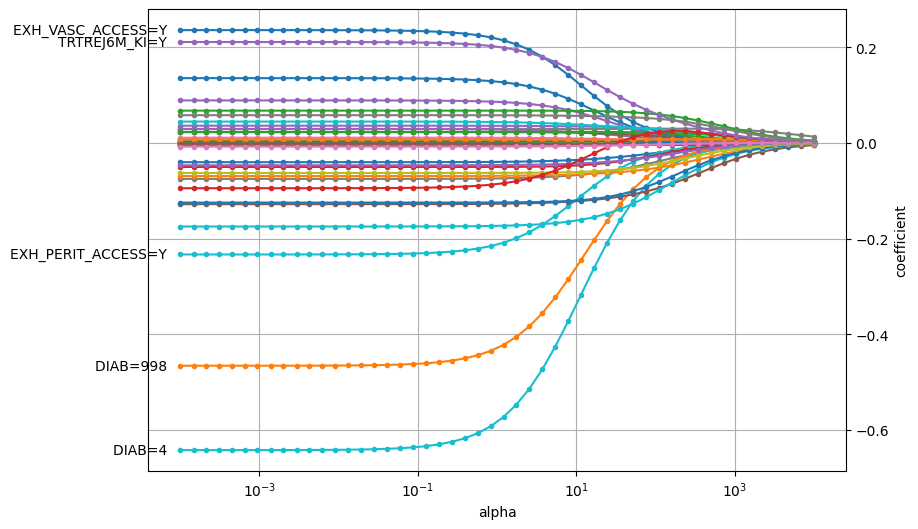

In [ ]:
plot_coefficients(coefficients, n_highlight=5)

### LASSO

In [ ]:
alphas = 10. ** np.linspace(-4, -1, 5)

In [ ]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas = alphas)
cox_lasso.fit(data_x_numeric, data_y)

CoxnetSurvivalAnalysis(alphas=array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ]),
                       l1_ratio=1.0)

In [ ]:
cox_lasso.alphas_

array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ])

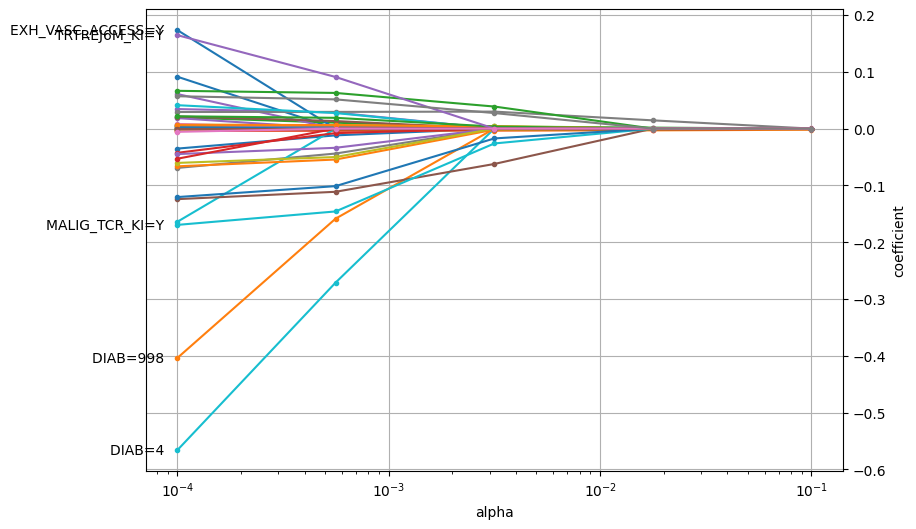

In [ ]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=data_x_numeric.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [ ]:
coefficients_lasso

,0.00010,0.00056,0.00316,0.01778,0.10000
ABO_MAT,-0.035179,-0.011901,0.000000,0.000000,0.000000
AGE_DON,-0.003483,-0.003420,-0.003402,-0.003089,-0.001991
BMI_DON_CALC,0.004572,0.004604,0.003727,0.001699,0.000000
BMI_TCR,-0.003519,-0.003365,-0.002791,-0.002065,0.000000
CMV_STATUS=P,0.034423,0.028336,0.000000,0.000000,0.000000
COLD_ISCH_KI,-0.000657,-0.000374,0.000000,0.000000,0.000000
DAYSWAIT_ALLOC,0.000028,0.000031,0.000034,0.000039,0.000042
DIAB=2,-0.069223,-0.043881,0.000000,0.000000,0.000000
DIAB=3,-0.001918,0.000000,0.000000,0.000000,0.000000
DIAB=4,-0.566016,-0.271247,0.000000,0.000000,0.000000


### Elastic Net

In [ ]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas = alphas)
cox_elastic_net.fit(data_x_numeric, data_y)

CoxnetSurvivalAnalysis(alphas=array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ]),
                       l1_ratio=0.9)

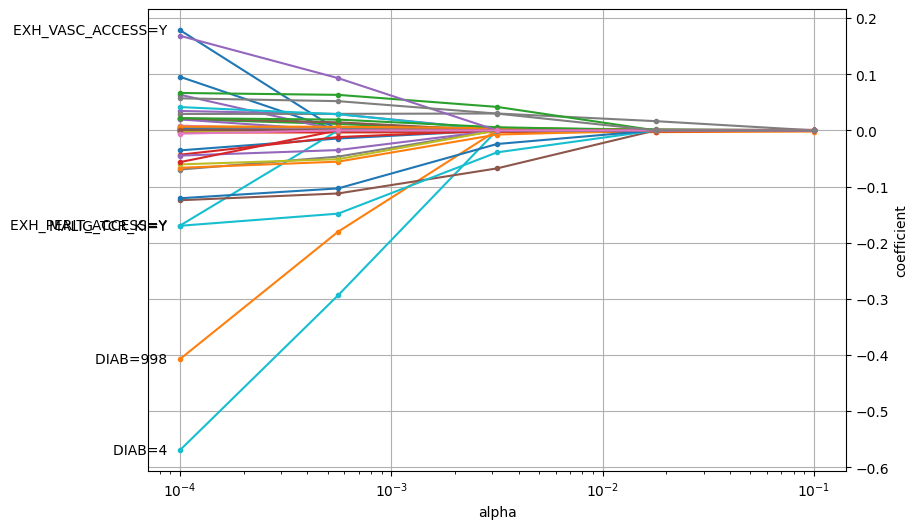

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=data_x_numeric.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [ ]:
coefficients_elastic_net

,0.00010,0.00056,0.00316,0.01778,0.10000
ABO_MAT,-0.035638,-0.014530,0.000000,0.000000,0.000000
AGE_DON,-0.003486,-0.003419,-0.003402,-0.003136,-0.002068
BMI_DON_CALC,0.004570,0.004614,0.003850,0.001847,0.000000
BMI_TCR,-0.003518,-0.003385,-0.002816,-0.002158,0.000000
CMV_STATUS=P,0.034569,0.028888,0.000959,0.000000,0.000000
COLD_ISCH_KI,-0.000664,-0.000397,0.000000,0.000000,0.000000
DAYSWAIT_ALLOC,0.000028,0.000031,0.000034,0.000038,0.000042
DIAB=2,-0.069755,-0.046707,0.000000,0.000000,0.000000
DIAB=3,-0.002119,0.000000,0.000000,0.000000,0.000000
DIAB=4,-0.569489,-0.293740,0.000000,0.000000,0.000000


In [ ]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

alphas = 10. ** np.linspace(-4, -1, 5)
# alphas = 10. ** np.linspace(-4, -1, 10)

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas = alphas) # alpha_min_ratio=0.01, max_iter=100
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(data_x_numeric, data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ]),
                                        l1_ratio=0.9))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(data_x_numeric, data_y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025136,0.001722,0.035863,0.000673,[0.0001],{'coxnetsurvivalanalysis__alphas': [0.0001]},0.507815,0.502907,0.514688,0.520180,0.528315,0.514781,0.008965,4
1,0.031533,0.003983,0.038561,0.002114,[0.0005623413251903491],{'coxnetsurvivalanalysis__alphas': [0.00056234...,0.508271,0.504467,0.514575,0.520675,0.529495,0.515497,0.008916,3
2,0.022319,0.002063,0.036967,0.003068,[0.0031622776601683794],{'coxnetsurvivalanalysis__alphas': [0.00316227...,0.513513,0.509185,0.511935,0.523782,0.529859,0.517655,0.007850,2
3,0.018016,0.000349,0.038186,0.001914,[0.01778279410038923],{'coxnetsurvivalanalysis__alphas': [0.01778279...,0.529371,0.509917,0.503631,0.543330,0.522975,0.521845,0.014096,1
4,0.016617,0.000540,0.036263,0.001668,[0.1],{'coxnetsurvivalanalysis__alphas': [0.1]},0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,5


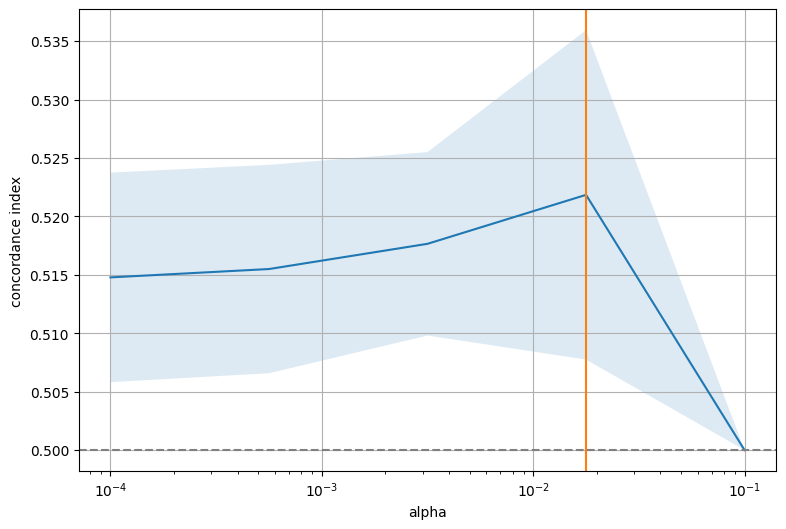

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.01778279410038923]}

Number of non-zero coefficients: 7


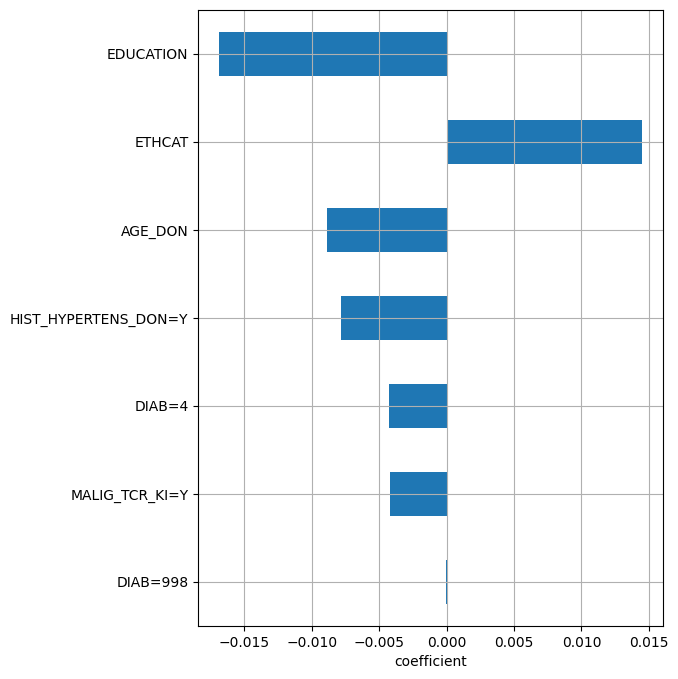

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=data_x_numeric.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Model 3: Random Forest

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [ ]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    data_x_numeric, data_y, test_size=0.25, random_state=random_state)

In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [ ]:
rsf.score(X_test, y_test) # 0.5451467811985269 with AGE_DIFF

0.546876450704419

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=random_state
)

In [ ]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
LOS,0.017313,0.005098
SERUM_CREAT,0.006445,0.003396
AGE_DON,0.004997,0.001490
ETHCAT,0.004168,0.006387
TOT_SERUM_ALBUM,0.003832,0.001653
END_CPRA,0.003501,0.001523
BMI_TCR,0.002878,0.003264
SHARE_TY=5,0.002269,0.000799
HIST_HYPERTENS_DON=Y,0.002230,0.001842
RT_KI_BIOPSY=Y,0.002021,0.000839


# Compare Model 1 and Model 3 with Time-dependent Brier Score

In [ ]:
rsf_gbsg = RandomSurvivalForest(max_depth=2, random_state=1)
rsf_gbsg.fit(X_train, y_train)

RandomSurvivalForest(max_depth=2, random_state=1)

In [ ]:
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True)
cph_gbsg.fit(X_train, y_train)

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)

In [ ]:
print(cph_gbsg.score)


<bound method SurvivalAnalysisMixin.score of CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.99)>


In [ ]:
score_cindex = pd.Series(
    [
        rsf_gbsg.score(X_test, y_test),
        cph_gbsg.score(X_test, y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"], name="c-index",
)

score_cindex.round(3)

RSF       0.528
CPH       0.523
Random    0.500
Name: c-index, dtype: float64

In [ ]:
lower, upper = np.percentile(data_y["GTIME_KI"], [10, 90])
data_times = np.arange(lower, upper + 1)

In [ ]:
rsf_surv_prob = np.row_stack([
    fn(data_times)
    for fn in rsf_gbsg.predict_survival_function(X_test)
])
cph_surv_prob = np.row_stack([
    fn(data_times)
    for fn in cph_gbsg.predict_survival_function(X_test)
])

In [ ]:
random_surv_prob = 0.5 * np.ones(
    (y_test.shape[0], data_times.shape[0])
)

In [ ]:
from sksurv.functions import StepFunction
from sksurv.nonparametric import kaplan_meier_estimator
km_func = StepFunction(
    *kaplan_meier_estimator(y_test["GSTATUS_KI"], y_test["GTIME_KI"])
)
km_surv_prob = np.tile(km_func(data_times), (y_test.shape[0], 1))

In [ ]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

score_brier = pd.Series(
    [
        integrated_brier_score(data_y, y_test, prob, data_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS"
)

pd.concat((score_cindex, score_brier), axis=1).round(6)

,c-index,IBS
RSF,0.527812,0.134962
CPH,0.522540,0.135007
Random,0.500000,0.250831
Kaplan-Meier,NaN,0.134953
